In [197]:
#для совместимости библиотек
#!pip install -r requirements.txt

## Введение

**Постановка задач**

Цель исследования - Cравнение классического и продвинутого алгоритма прогнозирования временных рядов <br>
Объект исследования – Алгоритм ARIMA, Алгоритм Prophet <br>
Предмет исследования – Данные по энергопотреблению в штате Техас (США)



**Обзор алгоритмов** <br>

ARIMA (Autoregressive Integrated Moving Average) и Prophet - это два широко используемых метода прогнозирования временных рядов. <br>
ARIMA - это статистический метод, который основан на моделировании авторегрессии, интегрированного среднего и скользящего среднего для прогнозирования будущих значений ряда. <br>
Prophet - это метод, разработанный Facebook для прогнозирования временных рядов, основанный на аддитивной регрессионной модели с гибкой сезонностью и изменяющейся средней.

ARIMA и Prophet оба позволяют моделировать и прогнозировать сложные временные ряды с различными трендами, сезонностью и шумом. 

Однако, существует некоторые отличия между этими методами. <br>
ARIMA является классическим методом прогнозирования временных рядов, который имеет множество настроек параметров, таких как порядок авторегрессии, порядок интегрирования и порядок скользящего среднего. <br>
Prophet же более продвинутый метод и ползволяет гибко настраивать параметры модели, такие как сезонность и праздники.

В зависимости от конкретной задачи, один метод может оказаться более подходящим, чем другой. <br>
ARIMA может быть полезен в случаях, когда ряд имеет явную сезонность и тренд. <br>
Prophet может быть предпочтительнее, если ряд имеет более сложную структуру и дополнительные факторы, такие как праздники или маркетинговые кампании.

В целом, выбор между ARIMA и Prophet зависит от конкретной задачи, доступных данных и предпочтений аналитика.

**Обзор данных**

Электрическая нагрузка
Для цели ислледования выбран датасет по электрической нагрузке компании American Electric Power(AEP) <br>
American Electric Power Company, Inc - крупная электроэнергетическая компания, принадлежащая инвесторам в США <br>
Она поставляет электроэнергию более чем пяти миллионам потребителей в 11 штатах, в числе которых Техас, Огайо и прочие другие. <br>

Исходный датасет найден на платформе kaggle по ссылке:
https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

Горизонт предоставляемых данных – (01.01.2005-01.01.2018) <br>
Периодичность данных – daily

Единица измерения – мегаватт <br>
Метрика качества – R^2(0%-100%)

Для удобства исследования почасовые данные были переведены в подневные

## ARIMA

Прогнозирование методом ARIMA выполняется на основе методолгии ее авторов Бокса и Дженкинса, изложенной в 1970-х годах.

В методологии вводится понятие стационарности временного ряда. <br>
Стационарность временного ряда - это свойство временного ряда, которое означает, что его статистические характеристики не меняются со временем. <br>
Другими словами, стационарный временной ряд имеет постоянное среднее значение и постоянную вариацию во времени. 

Методология также прописывает инструкцию в виде последовательности шагов, необходимых для реализации алгоритма:
1. Предварительное исследование графика временного ряда на стационарность и наличие сезонности
2. Проведение статистических тестов на предмет стационарности временного ряда - тест Дики-Фуллера
3. Разложение временного ряда на тренд, сезонность и шум. 
4. Определение оптимальных параметров Авторегрессии(AR), интегрированного среднего (I), скользящего среднего(MA) - график ACF, график PACF
5. Обучение алгоритма, проверка качества на обучающей и тестовых выборках 

In [198]:
#read_data

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
train = pd.read_csv('train.csv', index_col = 0, parse_dates=['ds']).set_index('ds')
train.head()

,y
ds,
2005-01-01,311897.0
2005-01-02,322712.0
2005-01-03,363937.0
2005-01-04,374003.0
2005-01-05,389445.0


Данные приведены к корректному формату

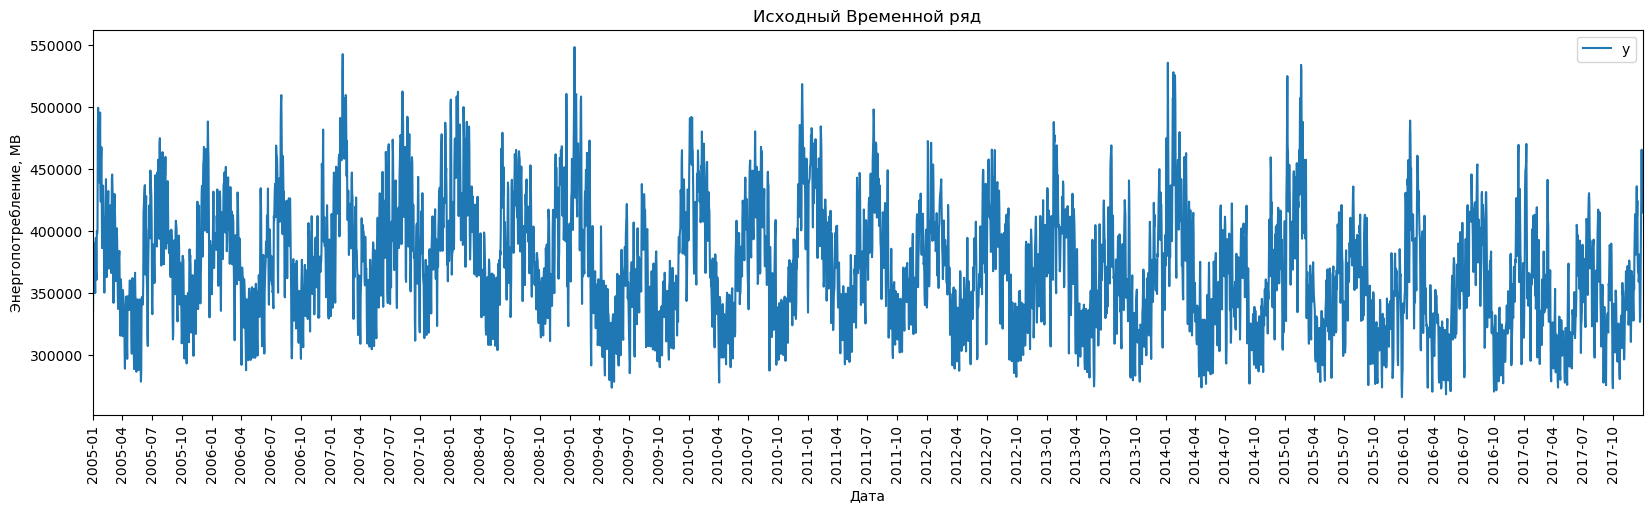

In [199]:
#Предварительное исследование графика временного ряда на стационарность и наличие сезонности

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
ax = train.plot(figsize = (20,5), xlabel = 'Дата', ylabel = 'Энергопотребление, МВ', title = 'Исходный Временной ряд')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)
plt.show()

Есть основания предварительно предположить стационарность ряда и наличие поквартальной сезонности

In [200]:
# Проверка стационарности тестом Дики-Фуллера

def test_stationarity(timeseries):
    
    from statsmodels.tsa.stattools import adfuller

    print('Results of Dickey-Fuller Test:')
    print ("==============================================")
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(
        dftest[0:4], 
        index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used']
    )
        
    print(dfoutput.round(3))
    
test_stationarity(train)

Results of Dickey-Fuller Test:
Test Statistic                   -7.31
p-value                           0.00
#lags Used                       30.00
Number of Observations Used    4717.00
dtype: float64


p-value в тесте Дики-Фуллера < 0.5 <br>
На примере имеющегося временного ряда подтверждается его стационарность

Подробнее про тест Дики-Фуллера: https://habr.com/ru/articles/314330/

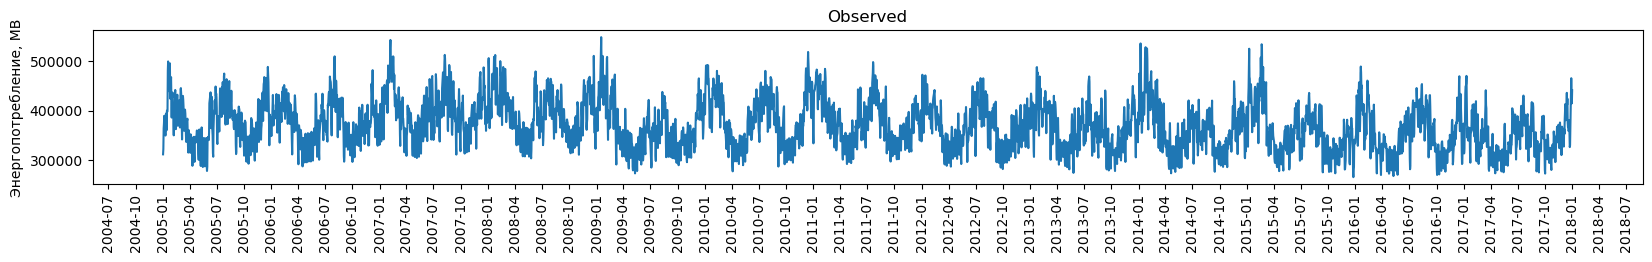

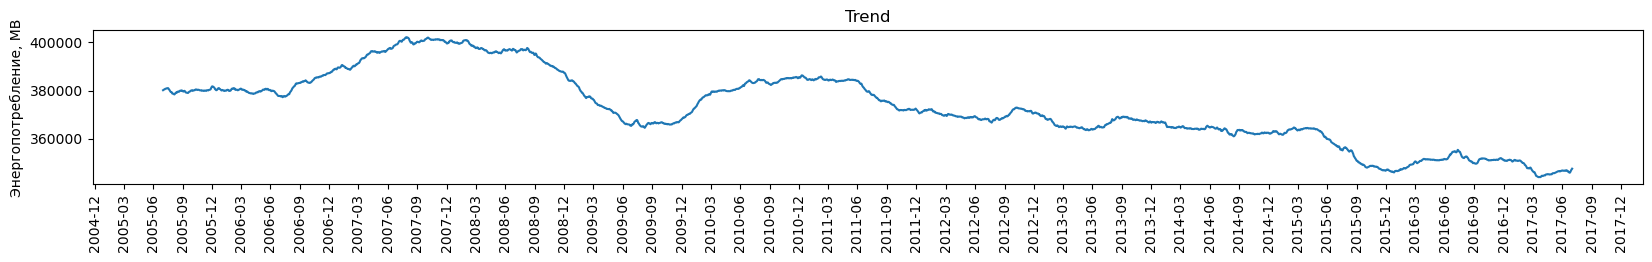

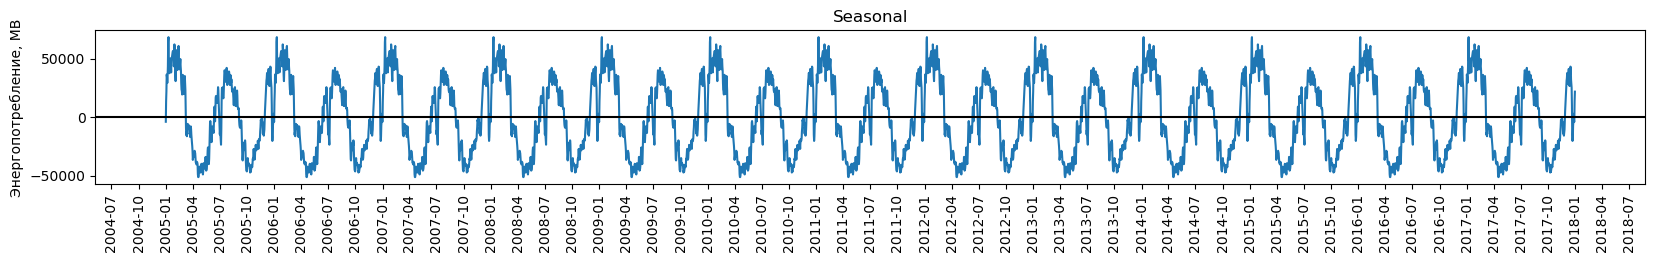

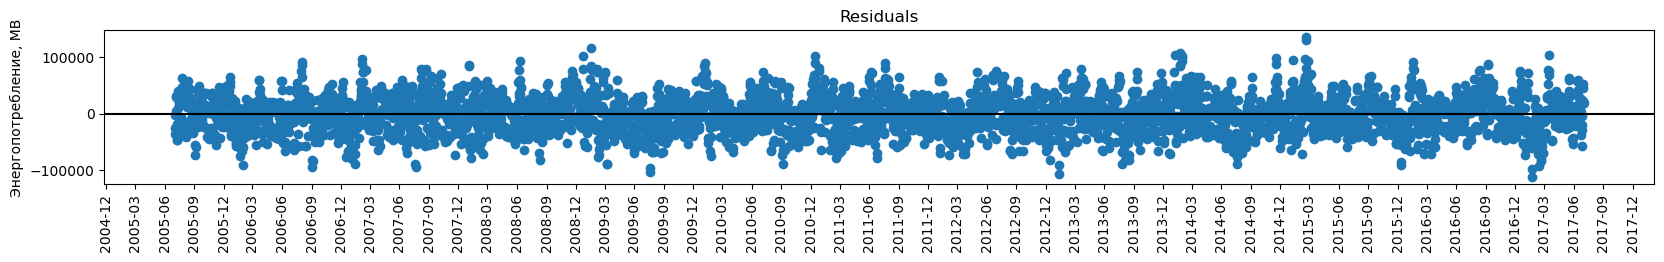

In [201]:
#Разложение временного ряда на тренд, сезонность и шум

import statsmodels.api as sm
import matplotlib.ticker as ticker
decomposition = sm.tsa.seasonal_decompose(train, model='additive', period = 365)

fig, ax = plt.subplots(figsize=(20, 2))
ax.plot(decomposition.observed.index, decomposition.observed.values)
ax.set_title('Observed')
ax.set_ylabel('Энергопотребление, МВ')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', rotation=90)

fig, ax = plt.subplots(figsize=(20, 2))
ax.plot(decomposition.trend.index, decomposition.trend.values)
ax.set_title('Trend')
ax.set_ylabel('Энергопотребление, МВ')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', rotation=90)

fig, ax = plt.subplots(figsize=(20, 2))
ax.plot(decomposition.seasonal.index, decomposition.seasonal.values, label='True values')
ax.axhline(y=0, color='k')
ax.set_title('Seasonal')
ax.set_ylabel('Энергопотребление, МВ')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', rotation=90)

fig, ax = plt.subplots(figsize=(20, 2))
ax.scatter(decomposition.resid.index, decomposition.resid.values, label='True values')
ax.axhline(y=0, color='k')
ax.set_title('Residuals')
ax.set_ylabel('Энергопотребление, МВ')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', rotation=90)

plt.show()

На графике сезонной компоненты видны:
* всплески электрической нагрузки относительно тренда в Q2 и Q4  <br>
* падения электрической нагрузки относительно тренда в Q1 и Q3

Подобное поведение объяснимо ростом энергопотребления в холодые периоды года

Подробнее про декомпозицию временного ряда: https://en.wikipedia.org/wiki/Decomposition_of_time_series

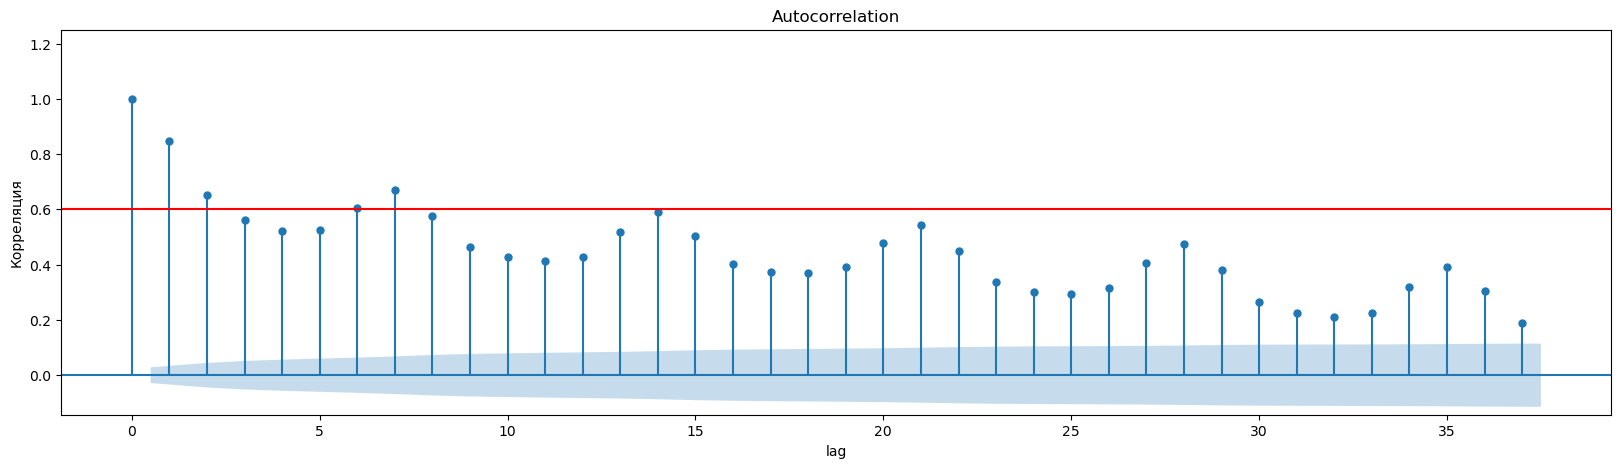

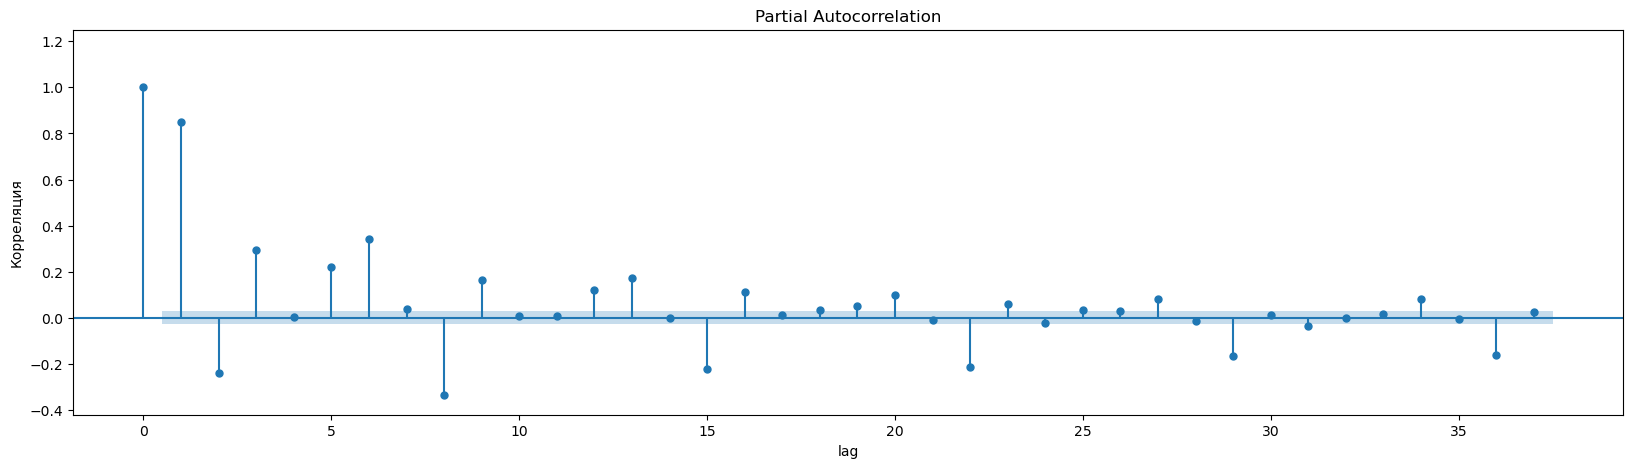

In [202]:
#Автокорреляционная функция
fig = sm.graphics.tsa.plot_acf(train, auto_ylims = True)
fig.set_size_inches((20, 5))
plt.axhline(0.6, color='r')
plt.xlabel('lag')
plt.ylabel('Корреляция')
plt.show()

#Частичная автокорелляция
fig = sm.graphics.tsa.plot_pacf(train, auto_ylims = True)
fig.set_size_inches((20, 5))
plt.xlabel('lag')
plt.ylabel('Корреляция')
plt.show()

Подбор параметров ARIMA-модели, включающей компоненты AR и MA, можно выполнить с помощью графиков автокорреляционной функции (ACF) и частной автокорреляционной функции (PACF) <br>
График ACF показывает корреляцию между временными рядами на разных лагах. <br>
График PACF показывает корреляцию между временным рядом и его лагами, после того, как были удалены корреляции, обусловленные более длинными лагами. <br>
Если на графике ACF имеется значительная автокорреляция на лаге p, а на графике PACF автокорреляция затухает медленно, то это может указывать на необходимость использования компоненты AR(p).

Для конкретного примера порог значительной автокорелляции возьмем за 0.6 <br>
На данных видно, что PACF затухает медленно, а значительная автокорелляция встречается до 3 лага включительно. <br>
Возьмем параметры ARIMA(3,0,3) <br>

Подробнее: http://www.machinelearning.ru/wiki/index.php?title=Автокорреляционная_функция <br>
Подробнее: http://www.machinelearning.ru/wiki/index.php?title=Частичная_автокорреляция

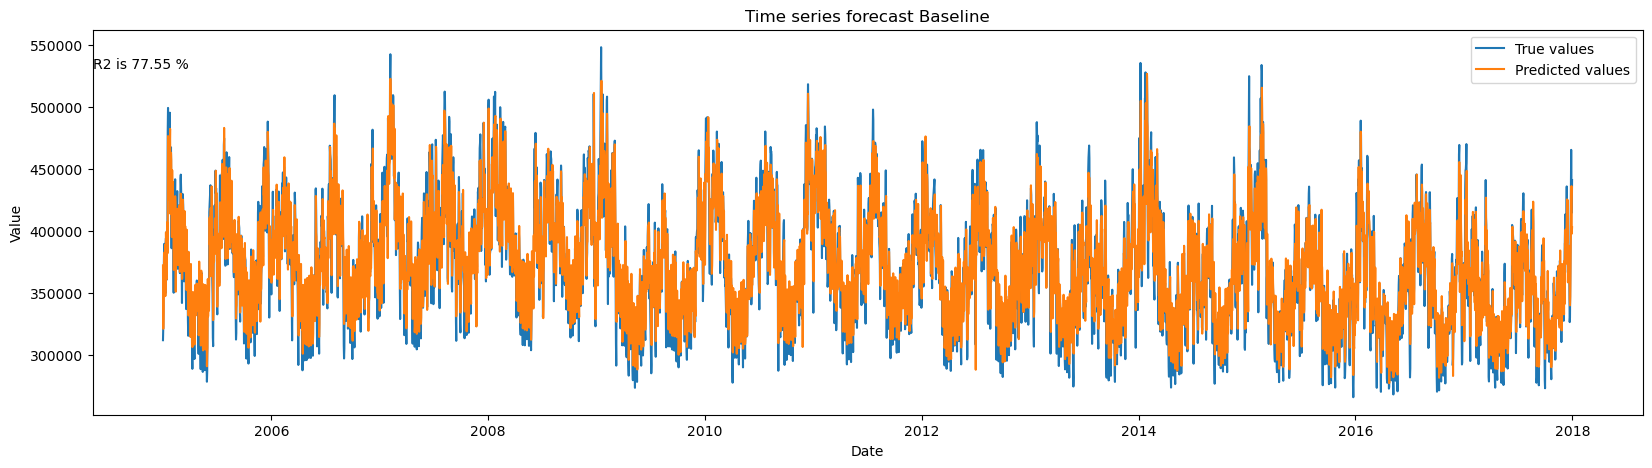

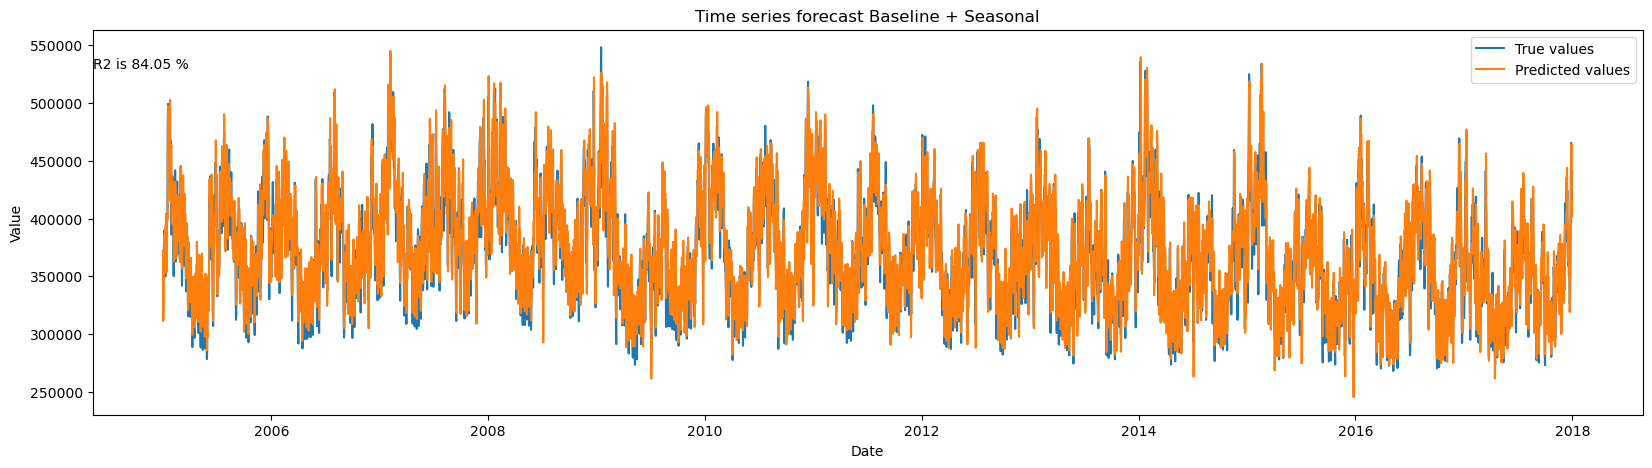

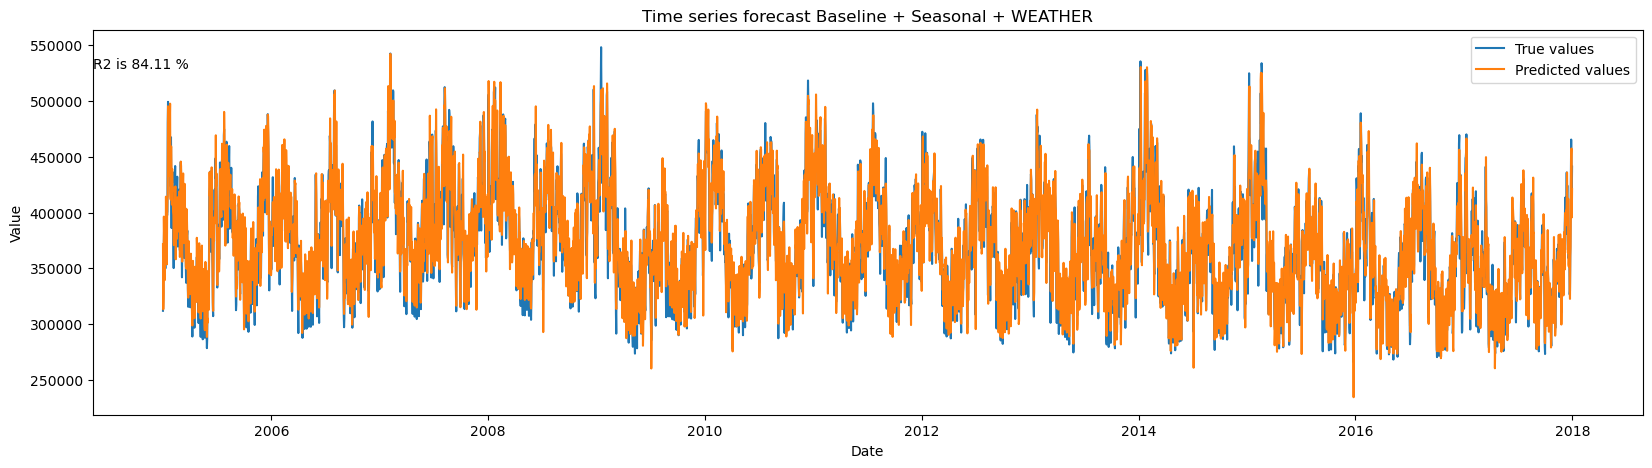

In [203]:
#ARIMA - baseline

#прогноз
model = sm.tsa.arima.ARIMA(
    endog=train,
    freq = 'D',
    order=(3, 0, 3),
    ).fit()
prediction = model.predict(start_idx=train.index.min(), end_idx = train.index.max())

#визуализация прогноза
from sklearn.metrics import mean_squared_error, r2_score
dates = train.index
y_true = train.values
y_pred = prediction.values

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(dates, y_true, label='True values')
ax.plot(dates, y_pred, label='Predicted values')
ax.set_title('Time series forecast Baseline')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
plt.text(0, 0.9, f'R2 is {round(r2_score(y_true, y_pred)*100,2)} %', fontsize = 10, transform=ax.transAxes)
plt.show()

#ARIMA - seasonal

#прогноз
model = sm.tsa.arima.ARIMA(
    endog=train,
    freq = 'D',
    order=(3, 0, 3),
    seasonal_order = (3,0,3,4)
    ).fit()
prediction = model.predict(start_idx=train.index.min(), end_idx = train.index.max())
model.save('arima_model.pickle')

#визуализация прогноза
from sklearn.metrics import r2_score
dates = train.index
y_true = train.values
y_pred = prediction.values

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(dates, y_true, label='True values')
ax.plot(dates, y_pred, label='Predicted values')
ax.set_title('Time series forecast Baseline + Seasonal')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
plt.text(0, 0.9, f'R2 is {round(r2_score(y_true, y_pred)*100,2)} %', fontsize = 10, transform=ax.transAxes)
plt.show()

#SARIMA - seasonal + endog

#прогноз
model = sm.tsa.arima.ARIMA(
    endog=train.y,
    freq = 'D',
    order=(3, 0, 3),
    seasonal_order = (3,0,3,4),
    exog = train.merge(pd.read_csv('texas_temp.csv', parse_dates = ['DATE'], usecols = ['DATE', 'TEMP', 'DEWP']).rename(columns = {'DATE':'ds'}).set_index('ds'), on = 'ds', how = 'left').fillna(method = 'ffill')[['TEMP', 'DEWP']]
    ).fit()
prediction = model.predict(start_idx=train.index.min(), end_idx = train.index.max())

#визуализация прогноза
from sklearn.metrics import r2_score
dates = train.index
y_true = train.y.values
y_pred = prediction.values

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(dates, y_true, label='True values')
ax.plot(dates, y_pred, label='Predicted values')
ax.set_title('Time series forecast Baseline + Seasonal + WEATHER')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
plt.text(0, 0.9, f'R2 is {round(r2_score(y_true, y_pred)*100,2)} %', fontsize = 10, transform=ax.transAxes)
plt.show()

В процессе обучения, модель дообучалась с учетом появления у нее новой информации. <br>
На первой итерации модель обучена на дефолтных настройках с подобрыннми гиперпараметрами. <br>
На второй итерации добавлена поквартальная сезонность <br>
На третьей итерации добавлены дополнительные параметры - среднесуточная температура и точка росы в штате Техас (данные взяты с сайта https://www.noaa.gov) <br>

Наибольшую точность, которую удалось достичь путем реализации методологии Бокса-Дженкинса составила 84.11%. <br>
Наибольший вклад в прирост точности прогноза был достигнут путем учета сезонности. <br>
Влияние погодных условий оказалось невелико <br>
Праздники не учитывались

Существенный 7% прирост в точности за счет выделения сезонной компоненты доказывает правильность ее определения на предыдущих шагах, а также обоснованность применения данного алгоритма для рядов с явной сезональостью.




## Prophet

Prophet - является современным продвинутым инструментом анализа временных рядов. <br>
Вся внутренняя методология работы с инструментом заключается просто в подборе корректных параметров объекта Prophet. <br>
Сюда входит и учет сезонности, учет праздников(недоступный для ARIMA), а также учет дополнительных переменных.

В отличие от ARIMA, Prophet не требует длительного предварительного анализа временного ряда, а также соблюдения предпосылки о стационарности. <br>
Prophet был изначально изобретен как понятный и удобный инструмент для быстрого прогнозирования и моментального принятия решений.

Специфика библиотеки больше заточена под такие задачи как анализ продаж, анализ маркетинговых компаний, <br>
где первоначальный ряд с малей долей вероятности будет стабиьльным во времени и где учет праздников может быть критически важным.

In [205]:
#read_data

import pandas as pd
train = pd.read_csv('train.csv', index_col = 0, parse_dates=['ds']).reset_index(drop=True)
train.head()

,ds,y
0,2005-01-01,311897.0
1,2005-01-02,322712.0
2,2005-01-03,363937.0
3,2005-01-04,374003.0
4,2005-01-05,389445.0


Отличительной особенностью Prophet является формат входных данных. <br>
В отличие от ARIMA, куда на вход подавался объект Series, в Prophet подается объект DataFrame из двух столбцов ds и y. <br>
Важно сохранить наименование столбцов для корректной работы библиотеки.

Данные приведены к корректному формату.

21:59:27 - cmdstanpy - INFO - Chain [1] start processing
21:59:28 - cmdstanpy - INFO - Chain [1] done processing


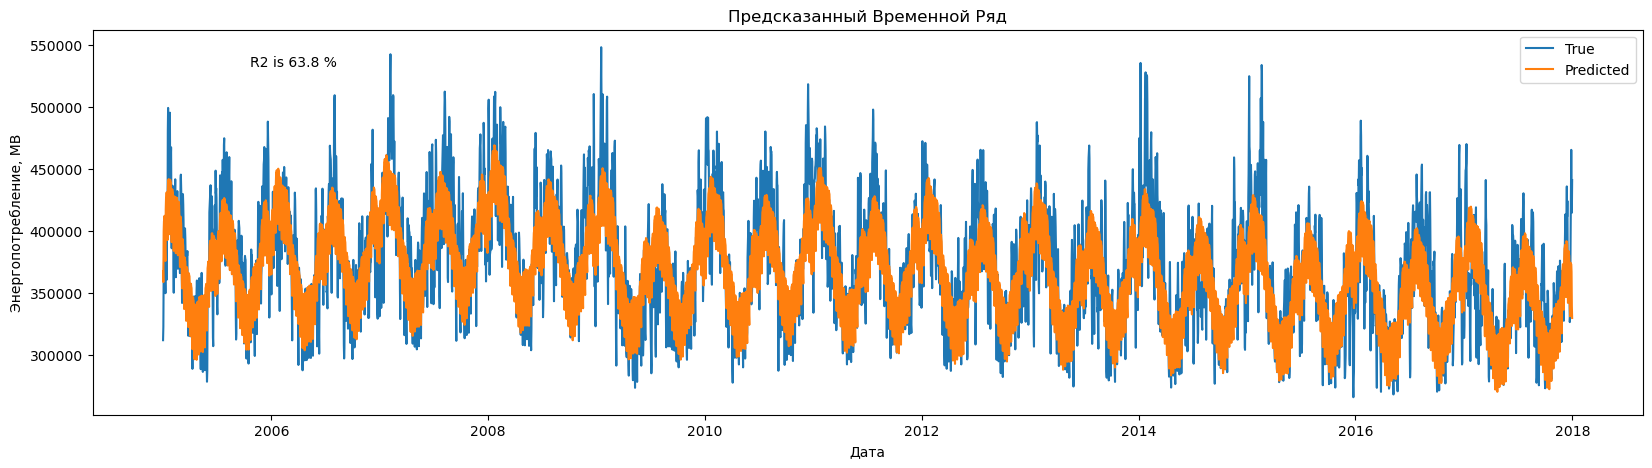

21:59:34 - cmdstanpy - INFO - Chain [1] start processing
21:59:43 - cmdstanpy - INFO - Chain [1] done processing


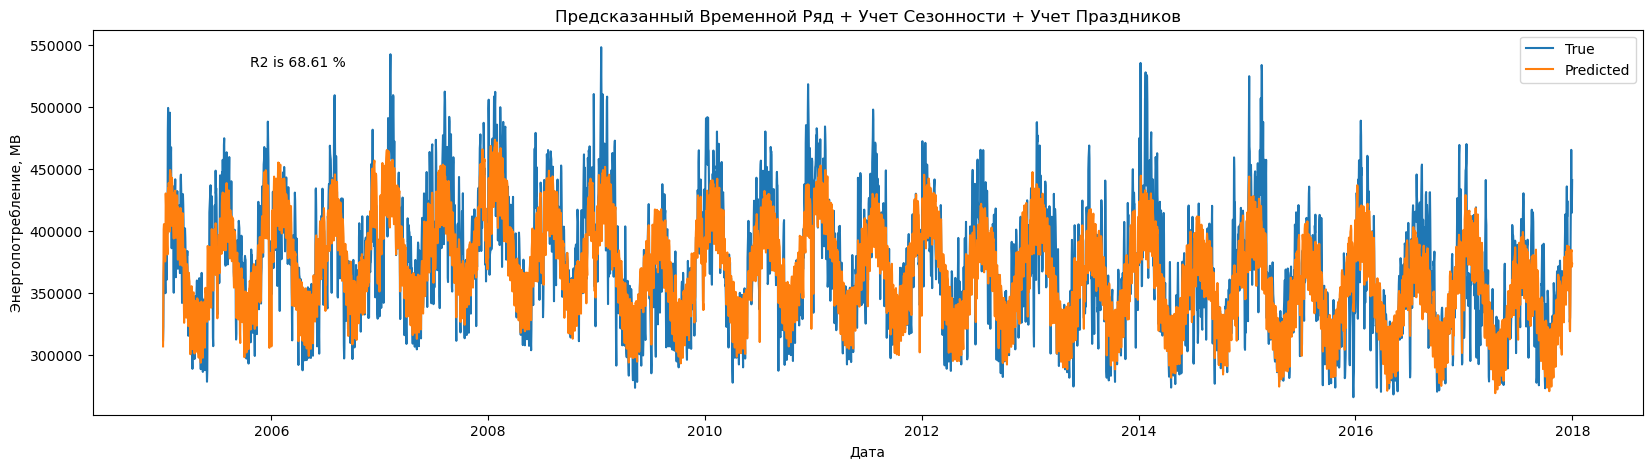

21:59:49 - cmdstanpy - INFO - Chain [1] start processing
22:00:02 - cmdstanpy - INFO - Chain [1] done processing


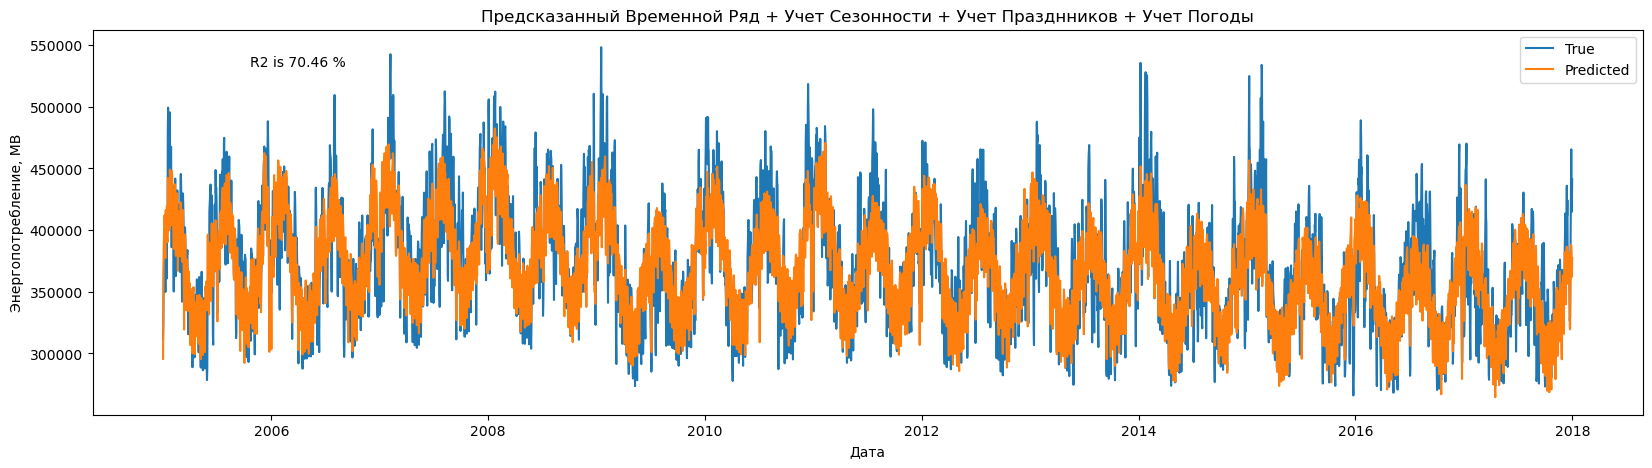

In [208]:
#прогноз
import pickle
from prophet import Prophet
model = Prophet()
model.fit(train)
prediction = model.predict(train)[['ds', 'yhat']]

#визуализация прогноза
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
y_true = train.set_index('ds').copy()
y_pred = prediction.set_index('ds').copy()
plt.figure(figsize=(20,5))
plt.plot(y_true, label = 'True')
plt.plot(y_pred, label = 'Predicted')
plt.xlabel('Дата')
plt.ylabel('Энергопотребление, МВ')
plt.title('Предсказанный Временной Ряд')
plt.legend()
plt.text(0, 0.9, f'R2 is {round(r2_score(y_true, y_pred)*100,2)} %', fontsize = 10, transform=ax.transAxes)
plt.show()

#прогноз
from prophet import Prophet
model = Prophet()
model.add_country_holidays(country_name='US')
model.add_seasonality(name='quarterly', period=91.25, fourier_order=300)
model.fit(train)
prediction = model.predict(train)[['ds', 'yhat']]
with open('prophet_model.pickle', 'wb') as f:
    pickle.dump(model, f)

#визуализация прогноза
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
y_true = train.set_index('ds').copy()
y_pred = prediction.set_index('ds').copy()
plt.figure(figsize=(20,5))
plt.plot(y_true, label = 'True')
plt.plot(y_pred, label = 'Predicted')
plt.xlabel('Дата')
plt.ylabel('Энергопотребление, МВ')
plt.title('Предсказанный Временной Ряд + Учет Сезонности + Учет Праздников')
plt.legend()
plt.text(0, 0.9, f'R2 is {round(r2_score(y_true, y_pred)*100,2)} %', fontsize = 10, transform=ax.transAxes)
plt.show()

#прогноз
df = pd.read_csv('texas_temp.csv', parse_dates = ['DATE'], usecols = ['DATE', 'TEMP', 'DEWP'])
df.columns = ['ds', 'temp', 'dewp']
train = train.merge(df, on = 'ds', how = 'left').fillna(method = 'ffill')

from prophet import Prophet
model = Prophet()
model.add_country_holidays(country_name='US')
model.add_seasonality(name='quarterly', period=91.25, fourier_order=300)
model.add_regressor('temp')
model.add_regressor('dewp')
model.fit(train)
prediction = model.predict(train)[['ds', 'yhat']]

#визуализация прогноза
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
y_true = train.set_index('ds')['y'].copy()
y_pred = prediction.set_index('ds').copy()
plt.figure(figsize=(20,5))
plt.plot(y_true, label = 'True')
plt.plot(y_pred, label = 'Predicted')
plt.xlabel('Дата')
plt.ylabel('Энергопотребление, МВ')
plt.title('Предсказанный Временной Ряд + Учет Сезонности + Учет Празднников + Учет Погоды')
plt.legend()
plt.text(0, 0.9, f'R2 is {round(r2_score(y_true, y_pred)*100,2)} %', fontsize = 10, transform=ax.transAxes)
plt.show()

Аналогично ARIMA модель дообучалась с учетом появления у нее новой информации.
На первой итерации модель обучена на дефолтных настройках <br>
На второй итерации добавлена поквартальная сезонность и праздники <br>
На третьей итерации добавлены дополнительные параметры - среднесуточная температура и точка росы в штате Техас (данные взяты с сайта https://www.noaa.gov) <br>

Наибольшую точность, которую удалось достичь составила 70.46% <br>
Как и в ARIMA, наибольший вклад в прирост точности прогноза был достигнут путем учета сезонности. <br>
Как и в ARIMA, погодные условия практически ничего не добавили в модель <br>
Влияние праздников также оказалось невелико <br>

## Тестирование

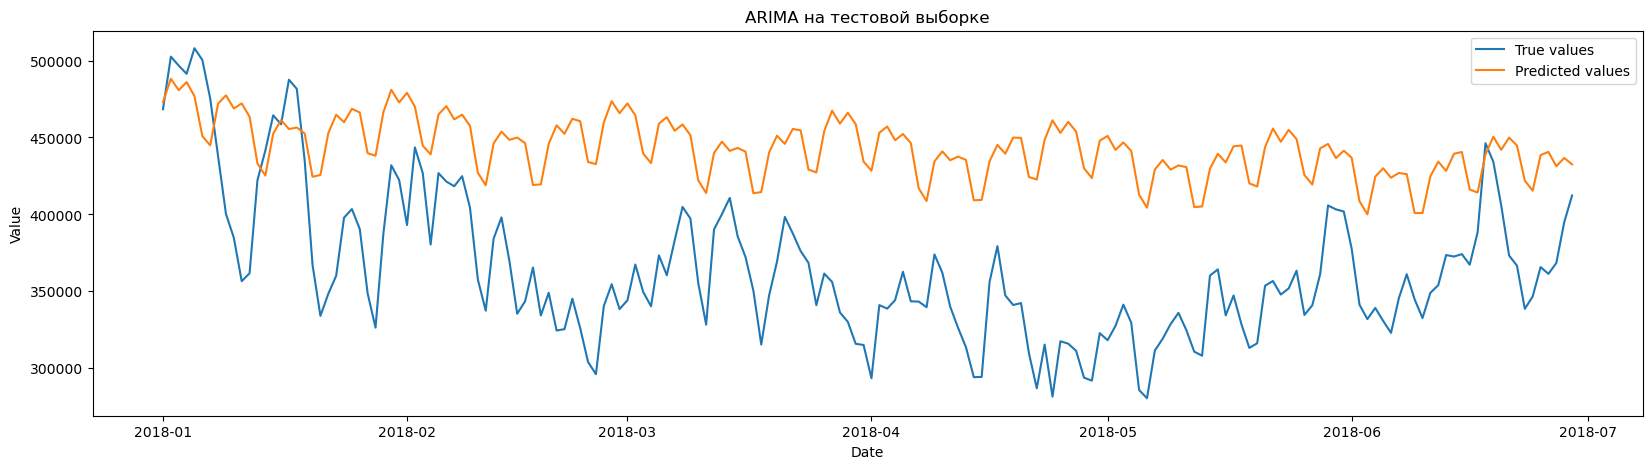

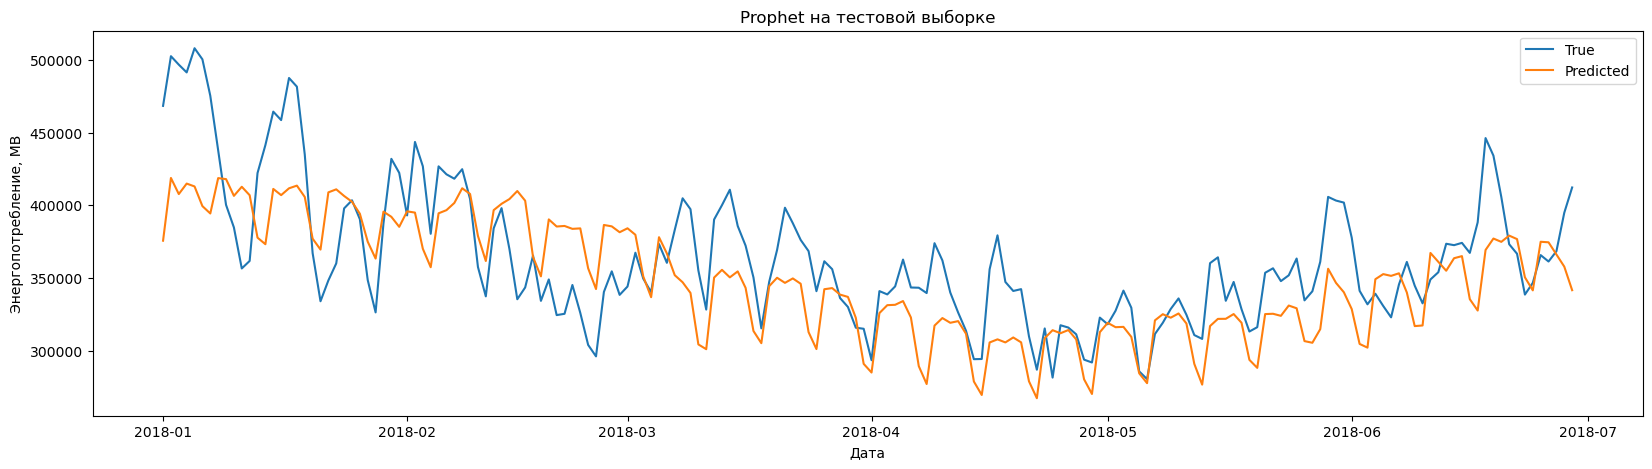

In [260]:
#ARIMA

steps = 180

model = pickle.load(open('arima_model.pickle', 'rb'))
test = pd.read_csv('test.csv', parse_dates=['ds'])[:steps]
prediction = model.forecast(steps = steps)

from sklearn.metrics import r2_score
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(test.set_index('ds'), label='True values')
ax.plot(prediction, label='Predicted values')
ax.set_title('ARIMA на тестовой выборке')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
plt.show()

#Prophet

steps = 180

test = pd.read_csv('test.csv', parse_dates=['ds']).reset_index(drop=True)[:steps]
model = pickle.load(open('prophet_model.pickle', 'rb'))
prediction = model.predict(test)[['ds', 'yhat']]

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
y_true = test.set_index('ds').copy()
y_pred = prediction.set_index('ds').copy()
plt.figure(figsize=(20,5))
plt.plot(y_true, label = 'True')
plt.plot(y_pred, label = 'Predicted')
plt.xlabel('Дата')
plt.ylabel('Энергопотребление, МВ')
plt.title('Prophet на тестовой выборке')
plt.legend()
plt.show()

## Вывод

???